# AI - Defect Predictor

# Getting repo

In [1]:
!git clone https://github.com/arpcs/defect-predictor.git

import sys
import os
sys.path.append('/content/defect-predictor')
os.chdir('/content/defect-predictor')

Cloning into 'defect-predictor'...
remote: Enumerating objects: 32938, done.
remote: Counting objects: 100% (32938/32938), done.
remote: Compressing objects: 100% (28241/28241), done.
remote: Total 32938 (delta 4430), reused 32139 (delta 3641), pack-reused 0
Receiving objects: 100% (32938/32938), 28.97 MiB | 7.31 MiB/s, done.
Resolving deltas: 100% (4430/4430), done.
Updating files: 100% (25833/25833), done.


In [2]:
!pip install requests
!pip install beautifulsoup4
!pip install OpenAI

import agents
import helper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


#Dataset

### Displaying basic stats about the Dataset

In [3]:
import os
import io
import json

# Directory path for the 'content' folder
problems_path = '/content/defect-predictor/codeforces_problems'

def problem_path_iterator(callback):
  ret = []
  for problem_pack_name in os.listdir(problems_path):
    problem_pack_path = os.path.join(problems_path, problem_pack_name)
    if not os.path.isfile(problem_pack_name):
      for name in os.listdir(problem_pack_path):
        full_path = os.path.join(problem_pack_path, name)
        if not os.path.isfile(full_path):
          full_file_path = os.path.join(full_path, "problem.txt")
          ret.append(callback(problem_pack_name, full_file_path, name))
  return ret

def solution_path_iterator(callback):
  ret = []
  for problem_pack_name in os.listdir(problems_path):
    problem_pack_path = os.path.join(problems_path, problem_pack_name)
    for root, dirs, files in os.walk(problem_pack_path):
        for file in files:
            if file != 'problem.txt':
              full_path = os.path.join(root, file)
              ret.append(callback(problem_pack_name, full_path, file))
  return ret

def read_json(file_path):
  try:
    with open(file_path, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        return json_data
  except Exception as e:
    print(f"Err file[{file_path}]: " + str(e))
  return None

def problem_getter():
  ret = problem_path_iterator(lambda _, full_path, _3: read_json(full_path))
  return ret

def solution_getter():
  ret = solution_path_iterator(lambda _, full_path, _3: read_json(full_path))
  return ret

# Iterating through each file in the directory
for folder_name in os.listdir(problems_path):
    problem_pack_path = os.path.join(problems_path, folder_name)
    if not os.path.isfile(folder_name):
      problem_count = len([name for name in os.listdir(problem_pack_path) if not os.path.isfile(os.path.join(problem_pack_path, name))])
      solution_count = 0
      for root, dirs, files in os.walk(problem_pack_path):
          for file in files:
              if file != 'problem.txt':
                  solution_count += 1
      print(f"In the folder \'{folder_name}\'\t Number of problems: {problem_count}")


num_of_problems = len(problem_path_iterator(lambda _, _2, _3: 1))
num_of_solutions = len(solution_path_iterator(lambda _, _2, _3: 1))
print(f"All Number of problems: {num_of_problems} \t Number of solutions : {num_of_solutions}")

problems = problem_getter()
solutions = solution_getter()

In the folder 'x10'	 Number of problems: 1022
In the folder 'x100'	 Number of problems: 124
All Number of problems: 1146 	 Number of solutions : 24679


## Plotting Dataset

Solution verdicts: {'OK': 12246, 'WRONG_ANSWER': 7699, 'RUNTIME_ERROR': 2354, 'COMPILATION_ERROR': 2345, 'PARTIAL': 26, 'FAILED': 9}
num_of_sol_categories: {'code optimization': 177, 'data structures': 157, 'error handling': 148, 'algorithm': 138, 'mathematics': 120, 'conditional statements': 118, 'dynamic programming': 111, 'code efficiency': 108, 'input/output handling': 106, 'code quality': 98, 'bit manipulation': 92, 'debugging': 86, 'c++ programming': 84, 'c++': 78, 'competitive programming': 76, 'code readability': 72, 'looping': 70, 'complexity analysis': 66, 'algorithms': 59, 'optimization': 56, 'problem solving': 52, 'integer operations': 50, 'memory management': 47, 'code structure': 46, 'array manipulation': 43, 'performance tuning': 43, 'number theory': 41, 'string manipulation': 39, 'variable declaration': 35, 'algorithm design': 34, 'graph theory': 32, 'input handling': 31, 'output formatting': 30, 'standard template library (stl)': 29, 'variable naming': 29, 'input/outpu

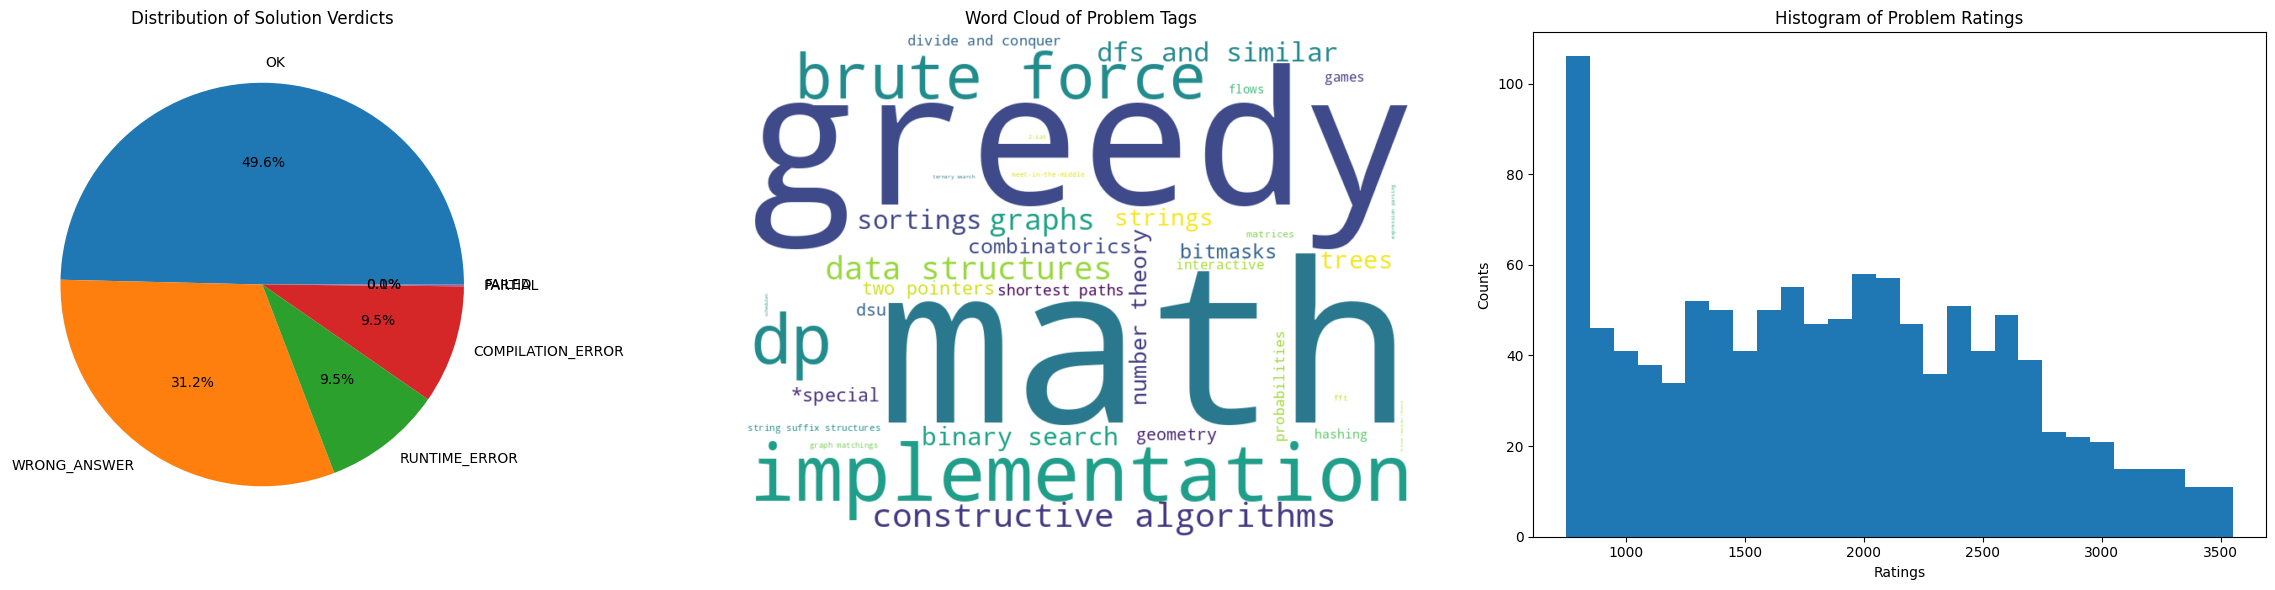

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

num_of_verdicts = {}
num_of_sol_categories = {}
num_of_languages = {}
for solution in solutions:
  if solution == None:
    continue
  verdict = solution.get("verdict")
  if verdict not in num_of_verdicts:
    num_of_verdicts[verdict] = 1
  else:
    num_of_verdicts[verdict] += 1

  language = solution.get("programmingLanguage")
  if language is not None:
    if language not in num_of_languages:
      num_of_languages[language] = 1
    else:
      num_of_languages[language] += 1

  categories = solution.get("suggested_categories")
  if categories is not None:
    for category in categories:
      if category not in num_of_sol_categories:
        num_of_sol_categories[category] = 1
      else:
        num_of_sol_categories[category] += 1

num_of_verdicts = dict(sorted(num_of_verdicts.items(), key=lambda x: x[1], reverse=True))
print(f"Solution verdicts: {str(num_of_verdicts)}")

num_of_sol_categories = dict(sorted(num_of_sol_categories.items(), key=lambda x: x[1], reverse=True))
print(f"num_of_sol_categories: {str(num_of_sol_categories)}")

num_of_tags = {}
num_of_types = {}
num_of_ratings = {}
num_of_prob_categories = {}
for problem in problems:
  if problem == None:
    continue
  tags = problem.get("tags")
  type_val = problem.get("type")
  rating = problem.get("rating")
  for tag in tags:
    if tag not in num_of_tags:
      num_of_tags[tag] = 1
    else:
      num_of_tags[tag] += 1
  if type_val not in num_of_types:
    num_of_types[type_val] = 1
  else:
    num_of_types[type_val] += 1
  if rating != None:
    if rating not in num_of_ratings:
      num_of_ratings[rating] = 1
    else:
      num_of_ratings[rating] += 1
  categories = problem.get("suggested_categories")
  if categories is not None:
    for category in categories:
      if category not in num_of_prob_categories:
        num_of_prob_categories[category] = 1
      else:
        num_of_prob_categories[category] += 1

num_of_tags = dict(sorted(num_of_tags.items(), key=lambda x: x[1], reverse=True))
print(f"Problem tags: {str(num_of_tags)}")

num_of_ratings = dict(sorted(num_of_ratings.items(), key=lambda x: x[1], reverse=True))
print(f"Problem types: {str(num_of_types)}")

num_of_prob_categories = dict(sorted(num_of_prob_categories.items(), key=lambda x: x[1], reverse=True))
print(f"num_of_prob_categories: {str(num_of_prob_categories)}")

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Pie chart for verdicts
axs[0].pie(num_of_verdicts.values(), labels=num_of_verdicts.keys(), autopct='%1.1f%%')
axs[0].set_title('Distribution of Solution Verdicts')

# Word cloud for tags
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(num_of_tags)
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].set_title('Word Cloud of Problem Tags')
axs[1].axis('off')

# Histogram for ratings
ratings, counts = zip(*num_of_ratings.items())
axs[2].bar(ratings, counts, width=100)
axs[2].set_title('Histogram of Problem Ratings')
axs[2].set_xlabel('Ratings')
axs[2].set_ylabel('Counts')

plt.tight_layout()
plt.show()

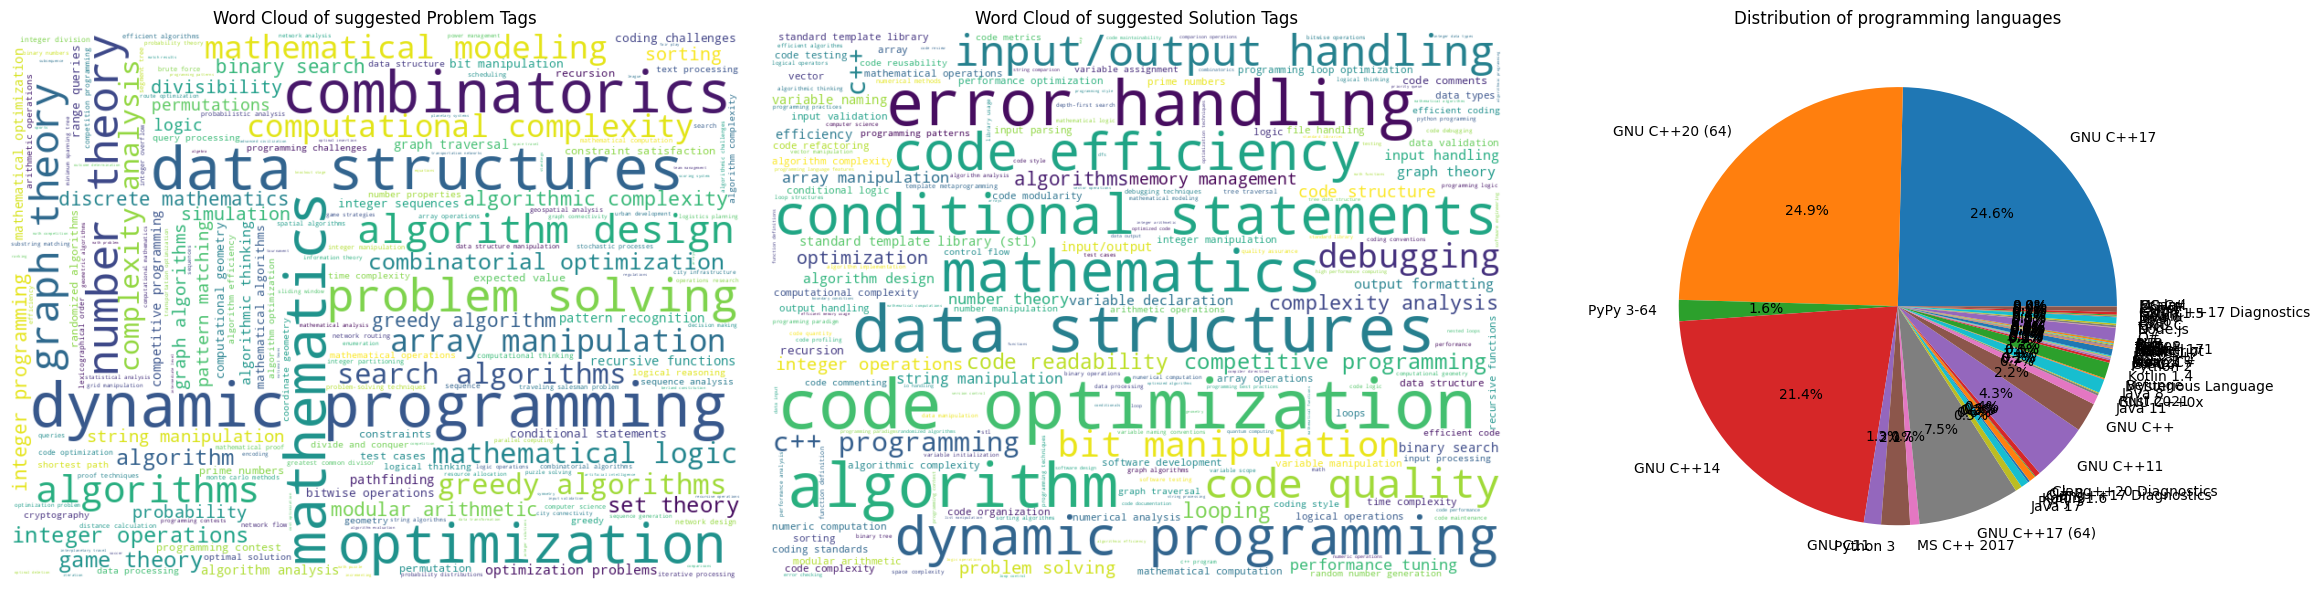

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Pie chart for verdicts
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(num_of_prob_categories)
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].set_title('Word Cloud of suggested Problem Tags')
axs[0].axis('off')

# Word cloud for tags
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(num_of_sol_categories)
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].set_title('Word Cloud of suggested Solution Tags')
axs[1].axis('off')

# Histogram for ratings
axs[2].pie(num_of_languages.values(), labels=num_of_languages.keys(), autopct='%1.1f%%')
axs[2].set_title('Distribution of programming languages')

plt.tight_layout()
plt.show()

## analyzing categories

In [6]:
sum_of_sol_categories = sum(count for category, count in num_of_sol_categories.items())
num_of_sol_categories_norm = [{category:(count / sum_of_sol_categories * 100)} for category, count in num_of_sol_categories.items() if count > sum_of_sol_categories / 100]
print(f"num_of_sol_categories: {str(num_of_sol_categories_norm)}")

sum_of_tags = sum(count for category, count in num_of_tags.items())
num_of_tags_norm = [{category:(count / sum_of_tags * 100)} for category, count in num_of_tags.items() if count > sum_of_tags / 100]
print(f"Problem tags: {str(num_of_tags_norm)}")

sum_of_prob_categories = sum(count for category, count in num_of_prob_categories.items())
num_of_prob_categories_norm = [{category:(count / sum_of_prob_categories * 100)} for category, count in num_of_prob_categories.items() if count > sum_of_prob_categories / 100]
print(f"num_of_prob_categories: {str(num_of_prob_categories_norm)}")

frequent_categories = [next(iter(category.keys())) for category in num_of_sol_categories_norm] +  [next(iter(category.keys())) for category in num_of_tags_norm] +  [next(iter(category.keys())) for category in num_of_prob_categories_norm]
print("frequent_categories: " + str(frequent_categories))

num_of_sol_categories: [{'code optimization': 3.5909920876445525}, {'data structures': 3.1852302698316093}, {'error handling': 3.002637451815784}, {'algorithm': 2.799756542909312}, {'mathematics': 2.4345709068776626}, {'conditional statements': 2.3939947250963685}, {'dynamic programming': 2.251978088861838}, {'code efficiency': 2.1911138161898966}, {'input/output handling': 2.1505376344086025}, {'code quality': 1.9882329072834246}, {'bit manipulation': 1.8665043619395416}, {'debugging': 1.7447758165956582}, {'c++ programming': 1.704199634814364}, {'c++': 1.582471089470481}, {'competitive programming': 1.5418949076891864}, {'code readability': 1.4607425441265978}, {'looping': 1.4201663623453034}, {'complexity analysis': 1.3390139987827145}, {'algorithms': 1.1969973625481842}, {'optimization': 1.1361330898762427}, {'problem solving': 1.054980726313654}, {'integer operations': 1.0144045445323595}]
Problem tags: [{'math': 10.713173466209904}, {'greedy': 10.277172220492059}, {'implementatio

# Selected categories
After evaluating the categores the following were selected:

['mathematics', 'dynamic programming', 'bit manipulation', 'greedy', 'brute force', 'graphs', 'sortings', 'search', 'trees', 'strings', 'number theory', 'combinatorics', 'two pointers', 'geometry', 'shortest paths', 'divide and conquer', 'probabilities', 'data structures', 'game theory', '2d, 3d', 'Recursive', 'Well-Commented', 'Self-Documenting', 'Complex', 'readable', 'Well-Named', 'Efficient', 'Reusable', 'Documented', 'Good error-Handling', 'Good solution', 'COMPILATION ERROR', 'RUNTIME ERROR']


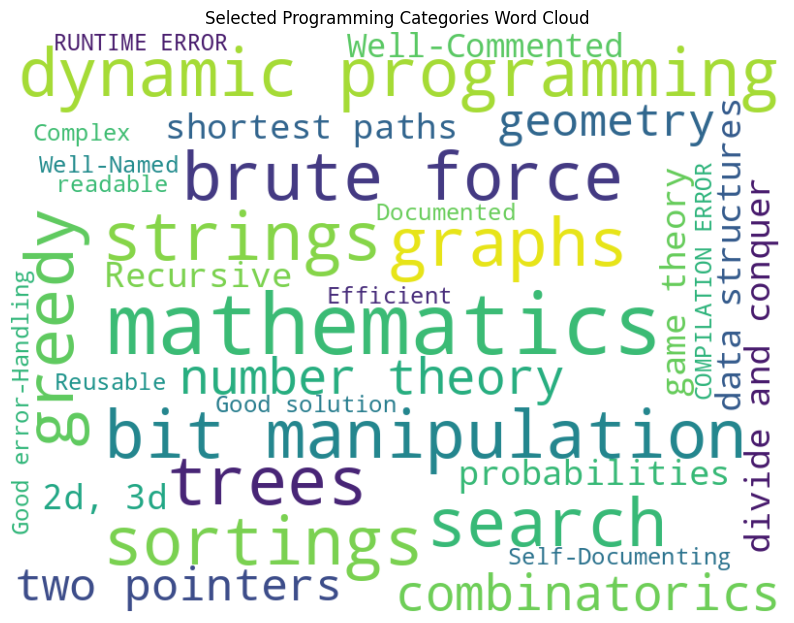

In [7]:
picked_categories = ['mathematics', 'dynamic programming', 'bit manipulation', 'greedy', 'brute force', 'graphs',
    'sortings', 'search', 'trees', 'strings', 'number theory', 'combinatorics', 'two pointers', 'geometry', 'shortest paths',
    'divide and conquer', 'probabilities', 'data structures', 'game theory', '2d, 3d','Recursive','Well-Commented','Self-Documenting',
    'Complex','readable','Well-Named','Efficient','Reusable','Documented','Good error-Handling', 'Good solution', 'COMPILATION ERROR', 'RUNTIME ERROR']
print(picked_categories)

category_freq = {category: 1 for category in picked_categories}

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(category_freq)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Selected Programming Categories Word Cloud')
plt.axis('off')
plt.show()

# Query results

In [8]:
problems = helper.problem_getter()
problem_paths = helper.problem_path_iterator(lambda _, full_path, _3: full_path)

solutions = helper.solution_getter()
solution_paths = helper.solution_path_iterator(lambda _, full_path, _3: full_path)
problem_solution_container = helper.ProblemSolutionContainer(problems, problem_paths, solutions, solution_paths)

problem_category_evaluation_count = agents.count_filed_category_evaluation(problems)
print(f"Already filled categories for problems: {problem_category_evaluation_count}")

solution_category_evaluation_count = agents.count_filed_category_evaluation(solutions)
print(f"Already filled categories for solutions: {solution_category_evaluation_count}")

defect_evaluation_count = agents.count_filed_defect_evaluation(solutions)
print(f"Already filled defect gpt3.5 evaluations: {defect_evaluation_count}")

defect_evaluation_gpt_4_count = agents.count_filed_defect_evaluation_gpt_4(solutions)
print(f"Already filled defect gpt4 evaluations: {defect_evaluation_gpt_4_count}")

Already filled categories for problems: 10
Already filled categories for solutions: 120
Already filled defect gpt3.5 evaluations: 100
Already filled defect gpt4 evaluations: 40


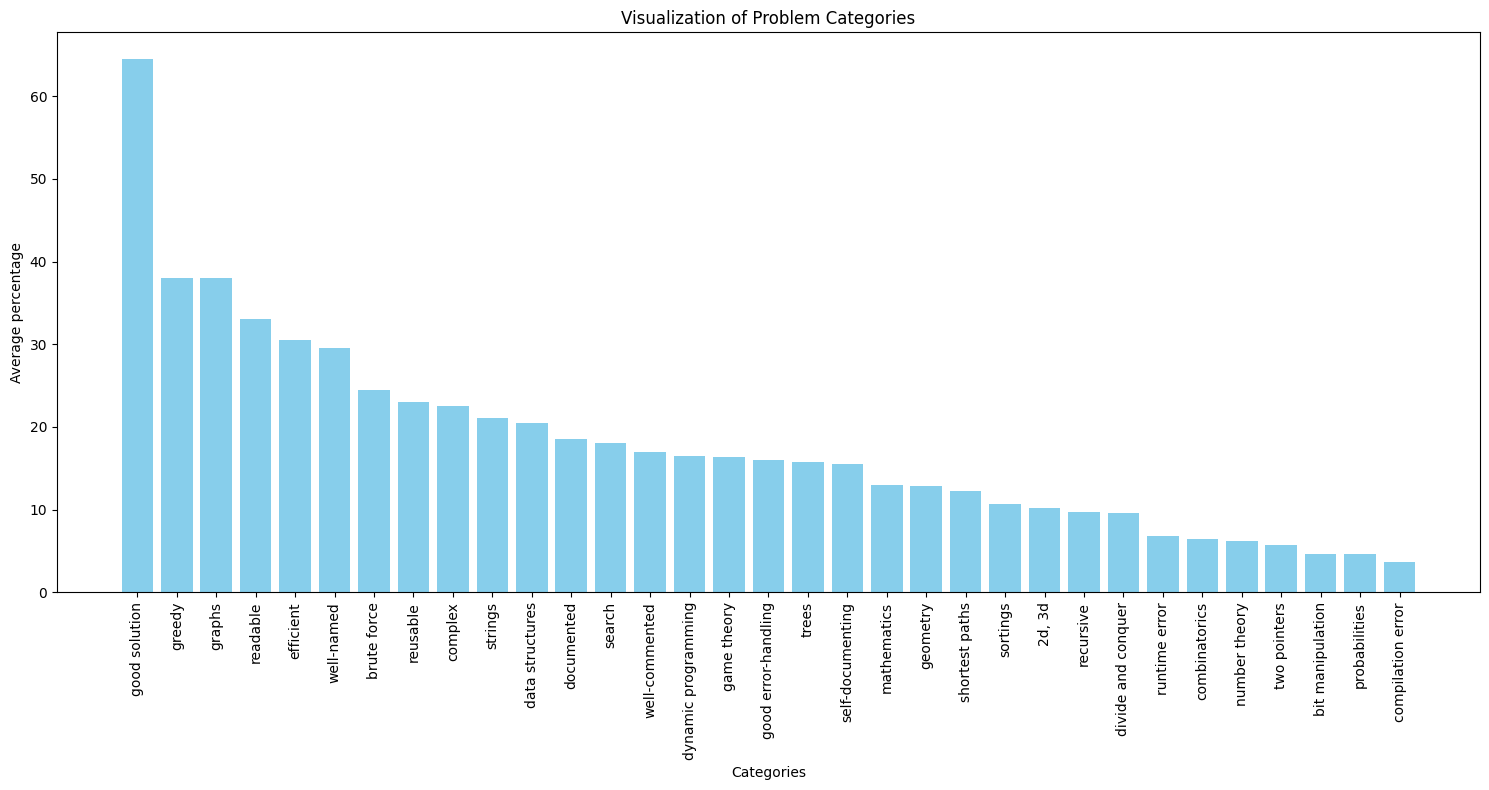

In [9]:
def visualize_evaluations(problems, name_of_dict, x_label, title):
  problems_with_categories = [probs_sol[name_of_dict] for probs_sol in problems if name_of_dict in probs_sol]

  # Combine the categories from all problems into one dictionary
  combined_categories = {}
  for category_eval in problems_with_categories:
      for category, value in category_eval.items():
          if category in combined_categories:
              combined_categories[category] += value / len(problems_with_categories)
          else:
              combined_categories[category] = value / len(problems_with_categories)

  # Sorting categories for better visualization
  sorted_categories = sorted(combined_categories.items(), key=lambda x: x[1], reverse=True)

  # Separating keys and values for plotting
  categories, values = zip(*sorted_categories)

  # Creating the bar plot
  plt.figure(figsize=(15, 8))  # Adjust the size as needed
  plt.bar(categories, values, color='skyblue')
  plt.xlabel(x_label)
  plt.ylabel('Average percentage')
  plt.title(title)
  plt.xticks(rotation=90)  # Rotate category names for readability
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area

  # Show the plot
  plt.show()

visualize_evaluations(problems, 'category_evaluation', 'Categories', 'Visualization of Problem Categories')


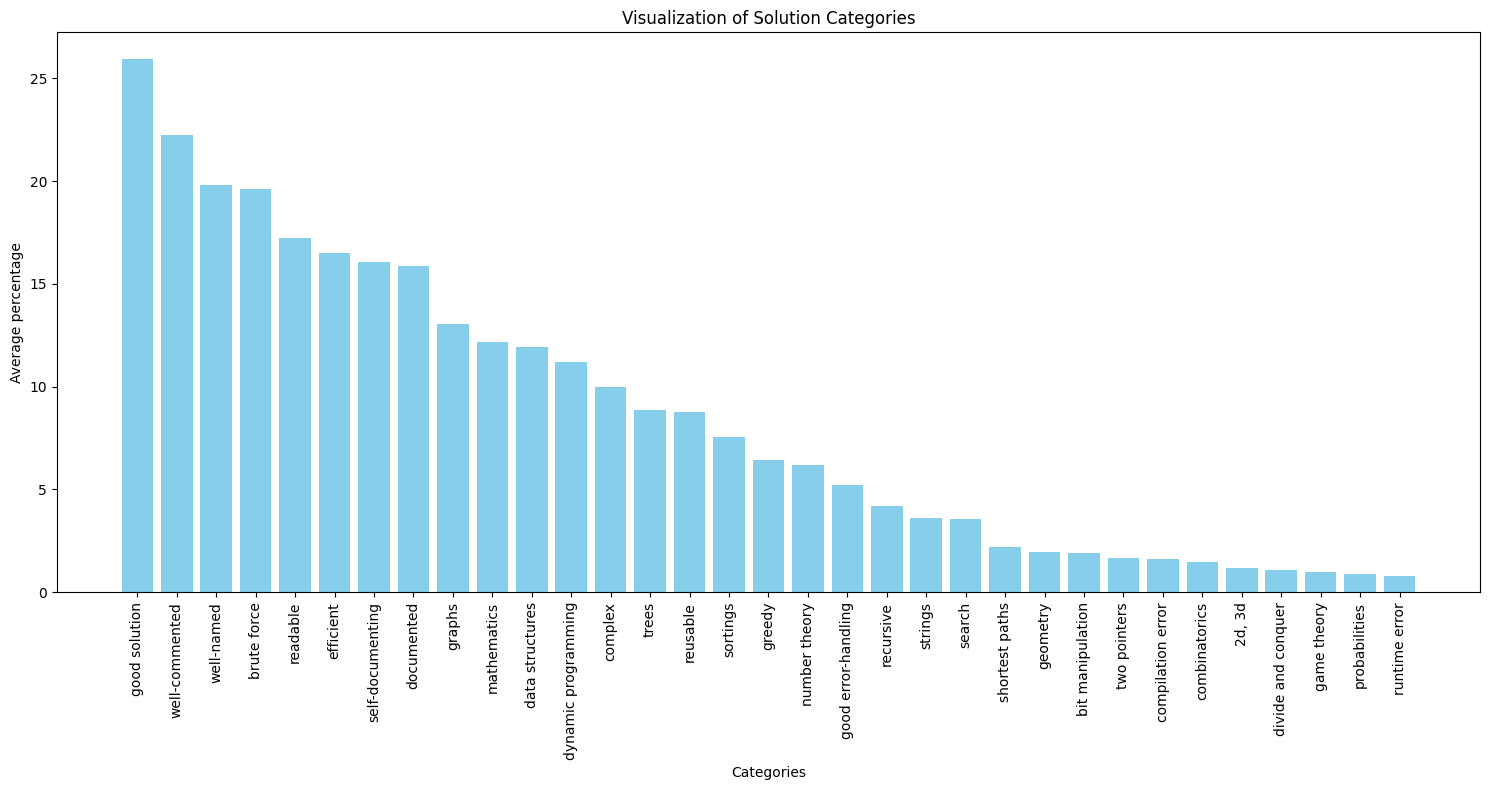

In [10]:
visualize_evaluations(solutions, 'category_evaluation', 'Categories', 'Visualization of Solution Categories')

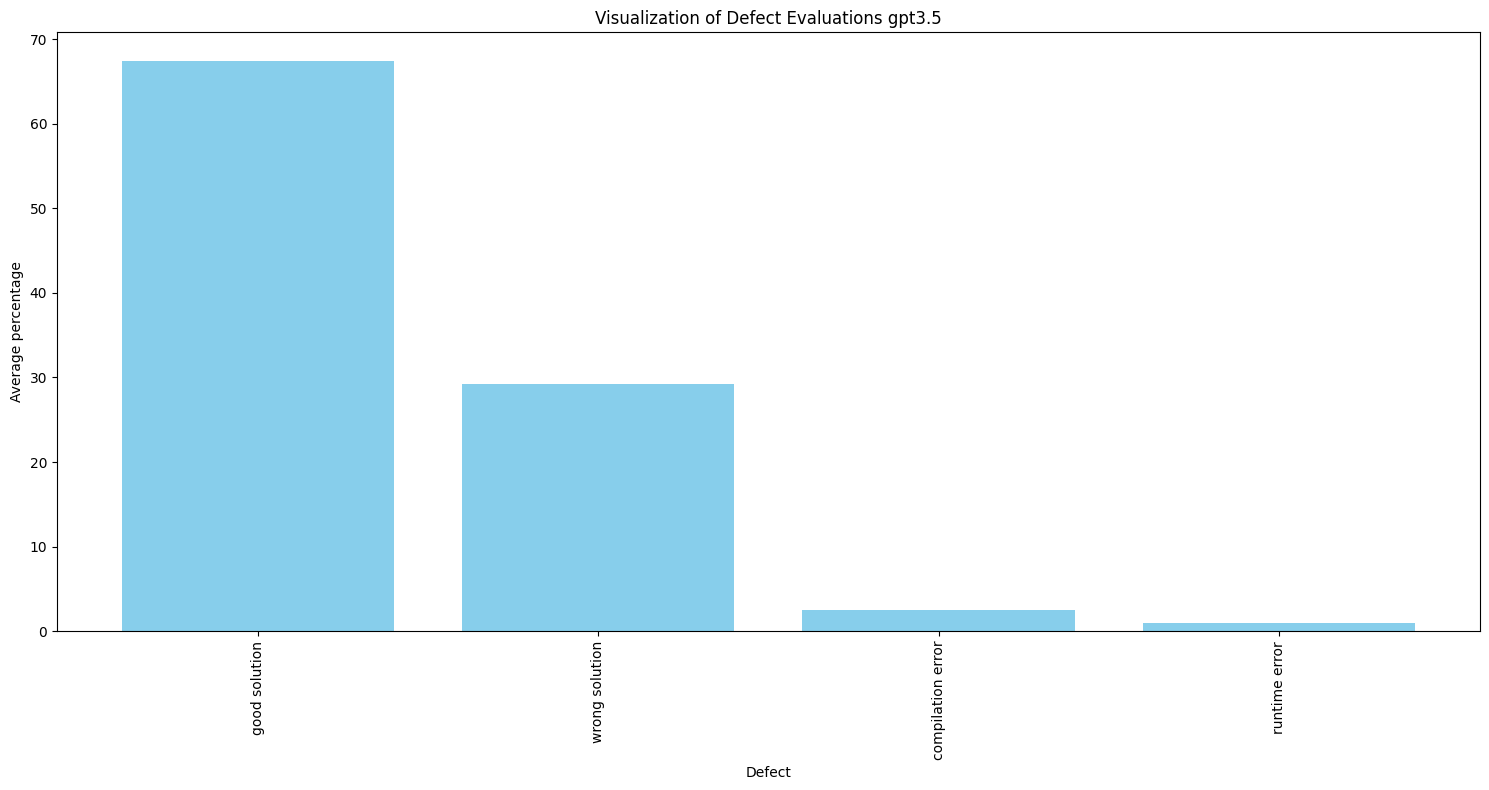

In [11]:
visualize_evaluations(solutions, 'defect_evaluation_v4', 'Defect', 'Visualization of Defect Evaluations gpt3.5')

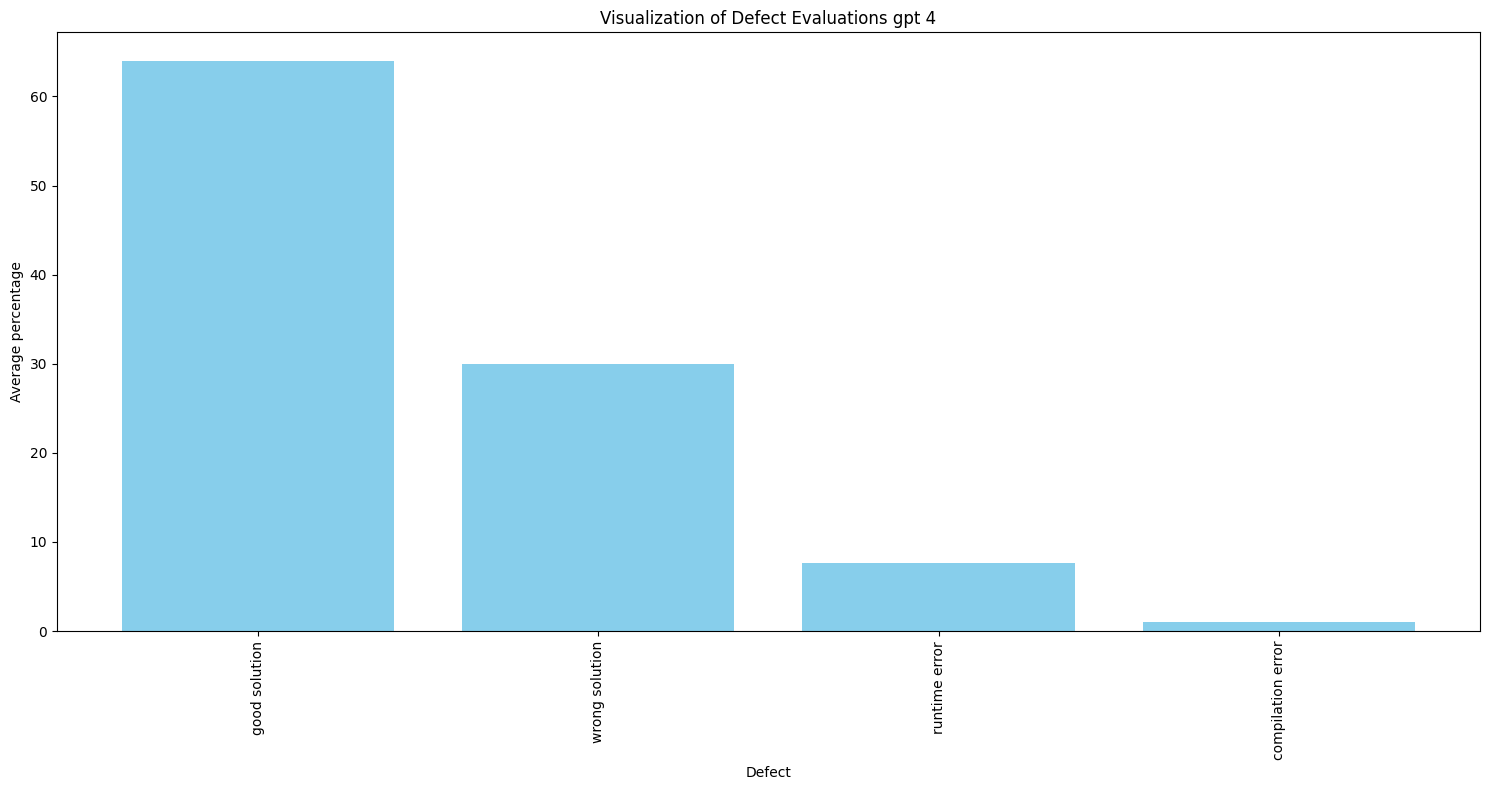

In [12]:
visualize_evaluations(solutions, 'defect_evaluation_gpt4_v4', 'Defect', 'Visualization of Defect Evaluations gpt 4')

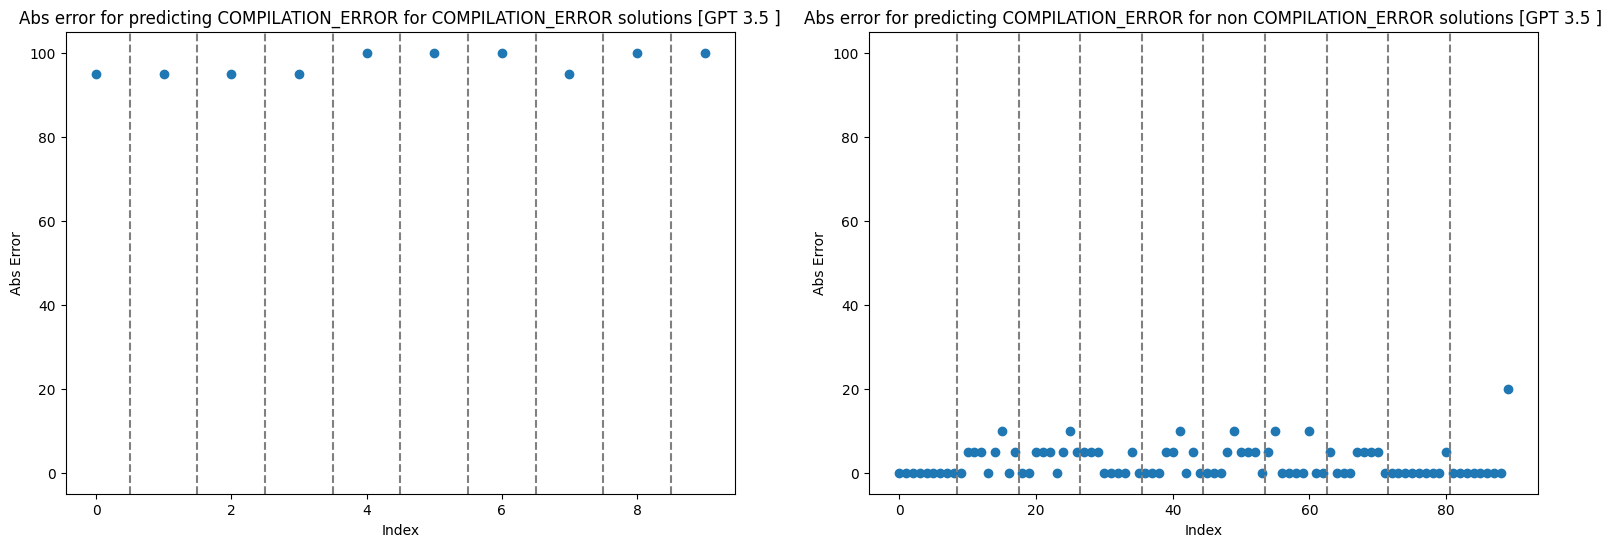

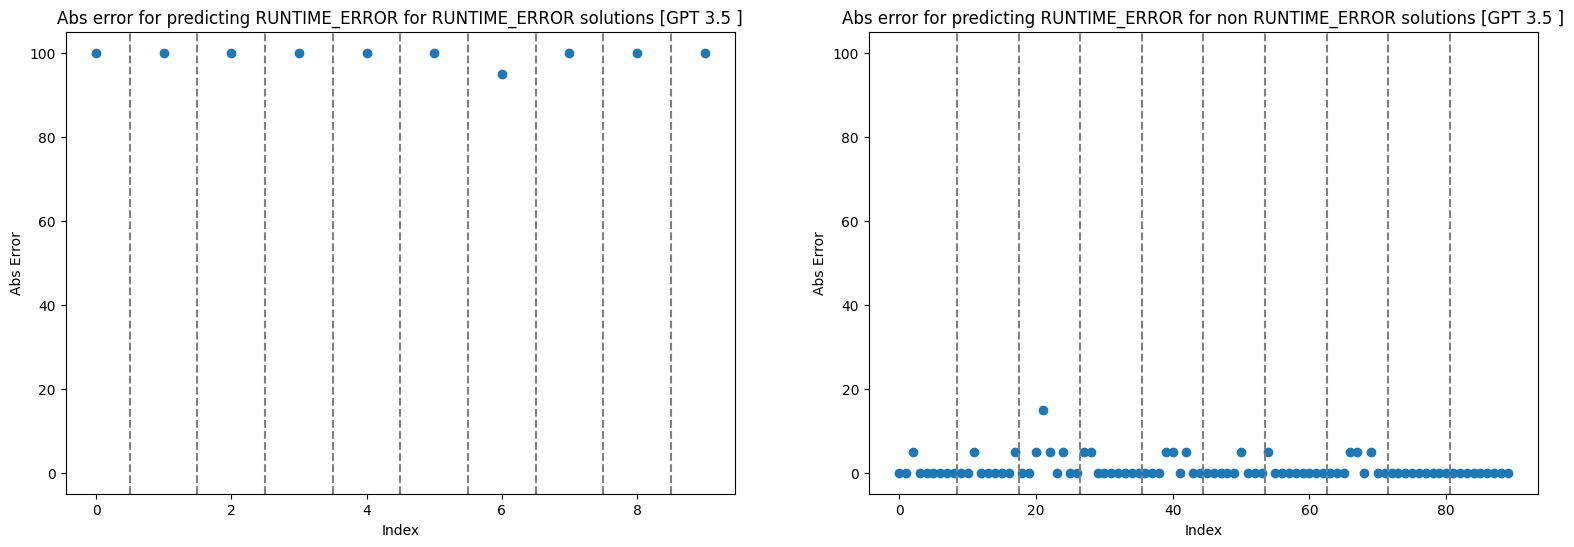

In [13]:
from operator import xor
verdicts_str = ["OK", "WRONG_ANSWER", "COMPILATION_ERROR", "RUNTIME_ERROR"]
eval_str = ["good solution","wrong solution","compilation error","runtime error"]

def plot_abs_dif(engine = "defect_evaluation_gpt4_v4", verdic_id = 0):
  fig, ax = plt.subplots(1,2, figsize=(19, 6))
  for idx, inverse in enumerate([False, True]):
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]

    grouped_sorted_val = [[solution.get('error')[verdic_id] for solution in solution_group if xor(solution['verdict'] == verdicts_str[ verdic_id ], inverse)  and 'error' in solution] for solution_group in solution_groups]

    # Flatten the list for plotting, while remembering the positions to draw lines
    flat_list = []
    lines_at = []
    current_pos = 0
    for group in grouped_sorted_val:
        flat_list.extend(group)
        current_pos += len(group)
        lines_at.append(current_pos-0.5)

    # Plot on the respective subplot
    ax[idx].scatter(range(len(flat_list)), flat_list)

    # Add line markers to the subplot
    for line in lines_at[:-1]:  # Exclude the last line
        ax[idx].axvline(x=line, color='grey', linestyle='--')

    # Adding labels and title to the subplot
    ax[idx].set_xlabel('Index')
    ax[idx].set_ylabel('Abs Error')
    ax[idx].set_title(f'Abs error for predicting {verdicts_str[verdic_id]} for {"non " if inverse else ""}{verdicts_str[verdic_id]} solutions [{"GPT 4" if "gpt4" in engine else "GPT 3.5 "}]')
    ax[idx].set_ylim(-5, 105)
  plt.show()

plot_abs_dif(engine = "defect_evaluation_v4",  verdic_id =  2)
plot_abs_dif(engine = "defect_evaluation_v4",  verdic_id =  3)

## Compilation error and runtime error predictions are pretty bad for gpt3.5.

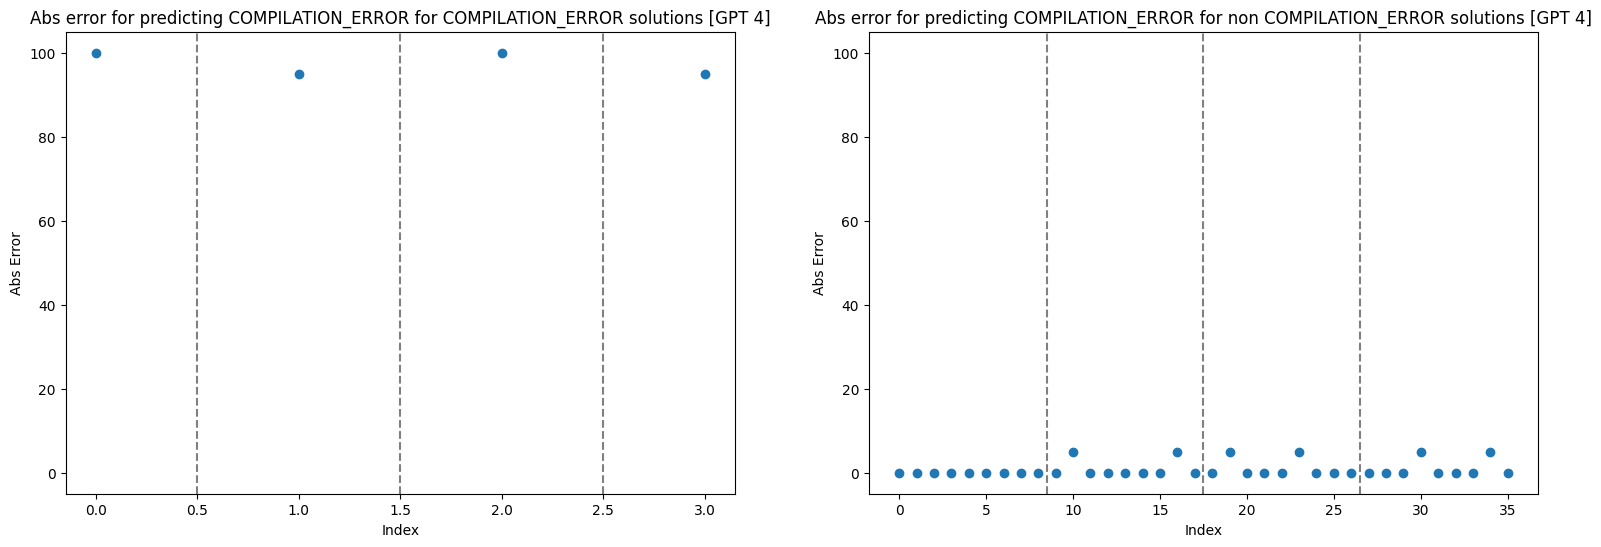

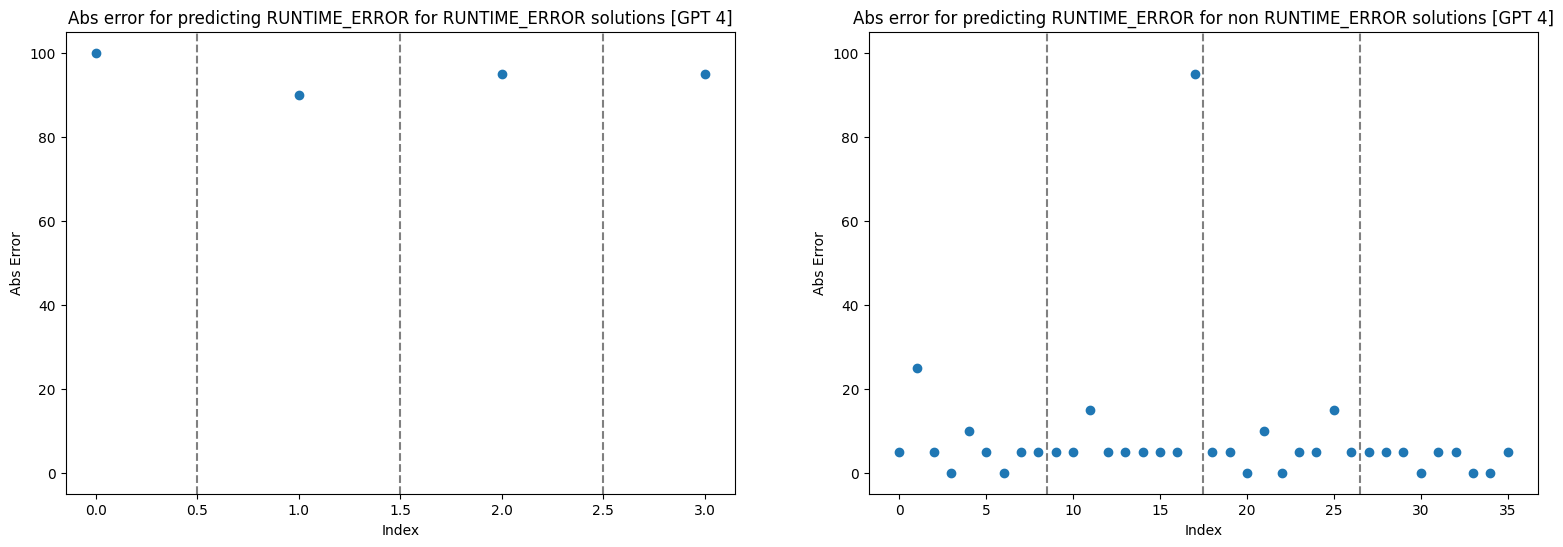

In [14]:
plot_abs_dif(engine = "defect_evaluation_gpt4_v4",  verdic_id =  2)
plot_abs_dif(engine = "defect_evaluation_gpt4_v4",  verdic_id =  3)

For gpt4 it's not better

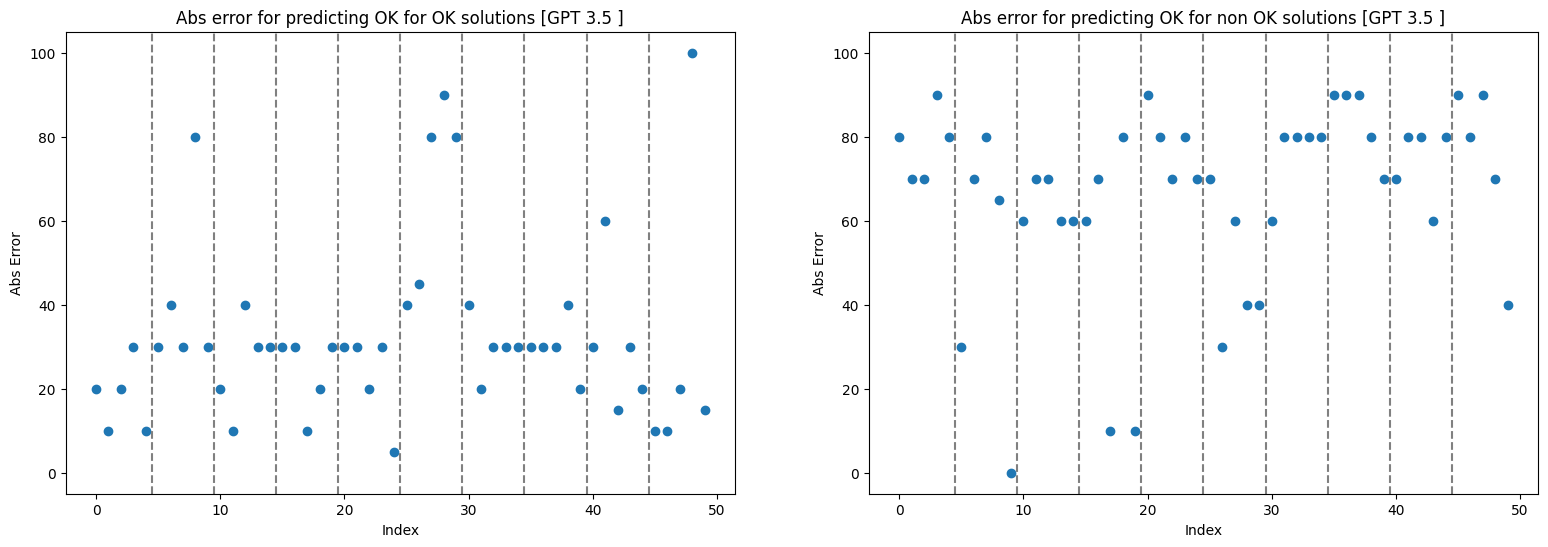

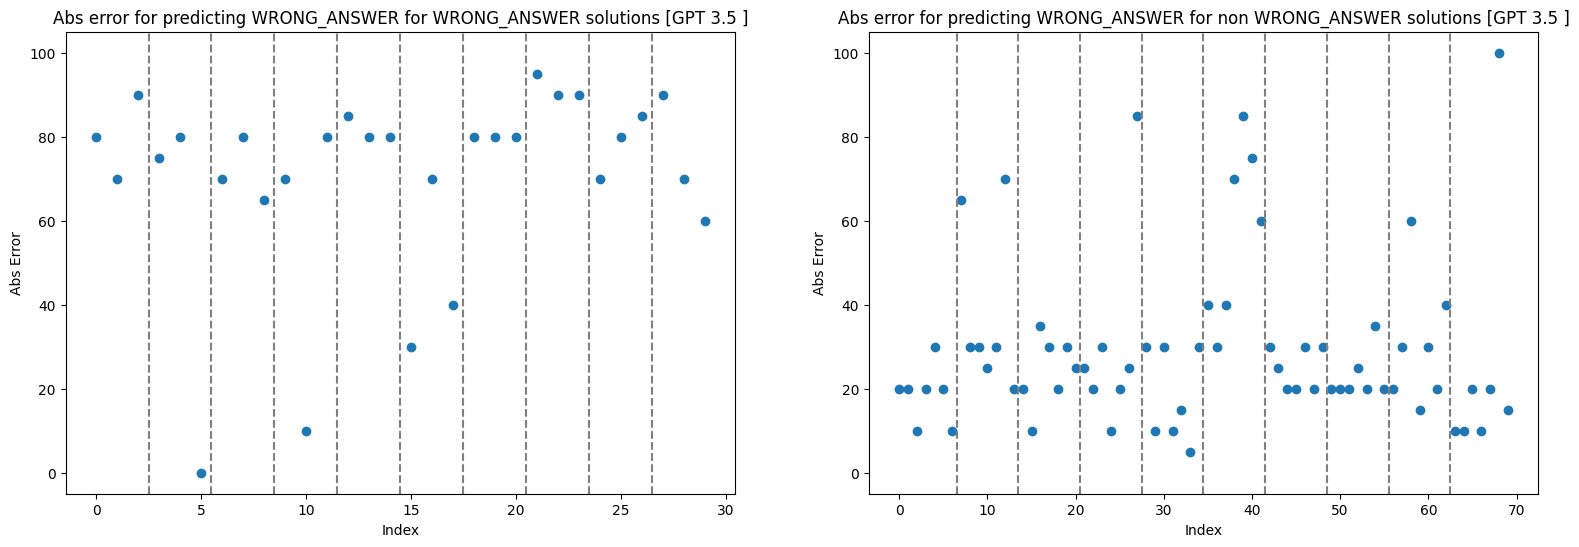

In [15]:
plot_abs_dif(engine = "defect_evaluation_v4",  verdic_id =  0)
plot_abs_dif(engine = "defect_evaluation_v4",  verdic_id =  1)

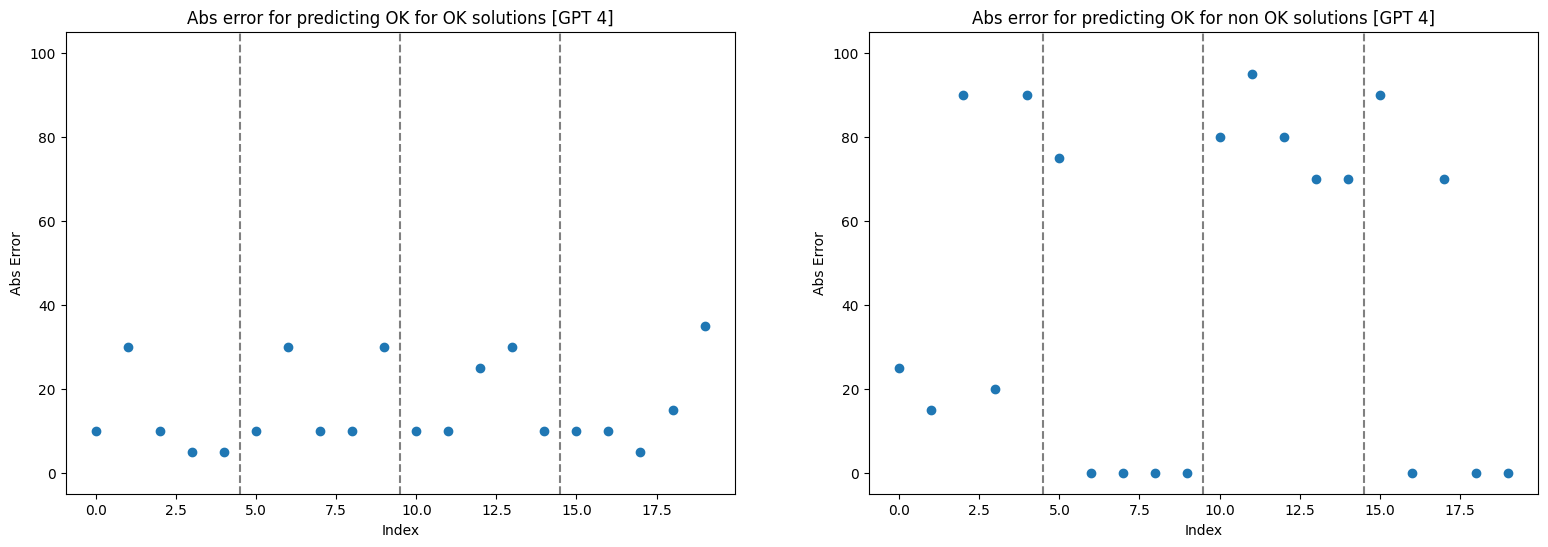

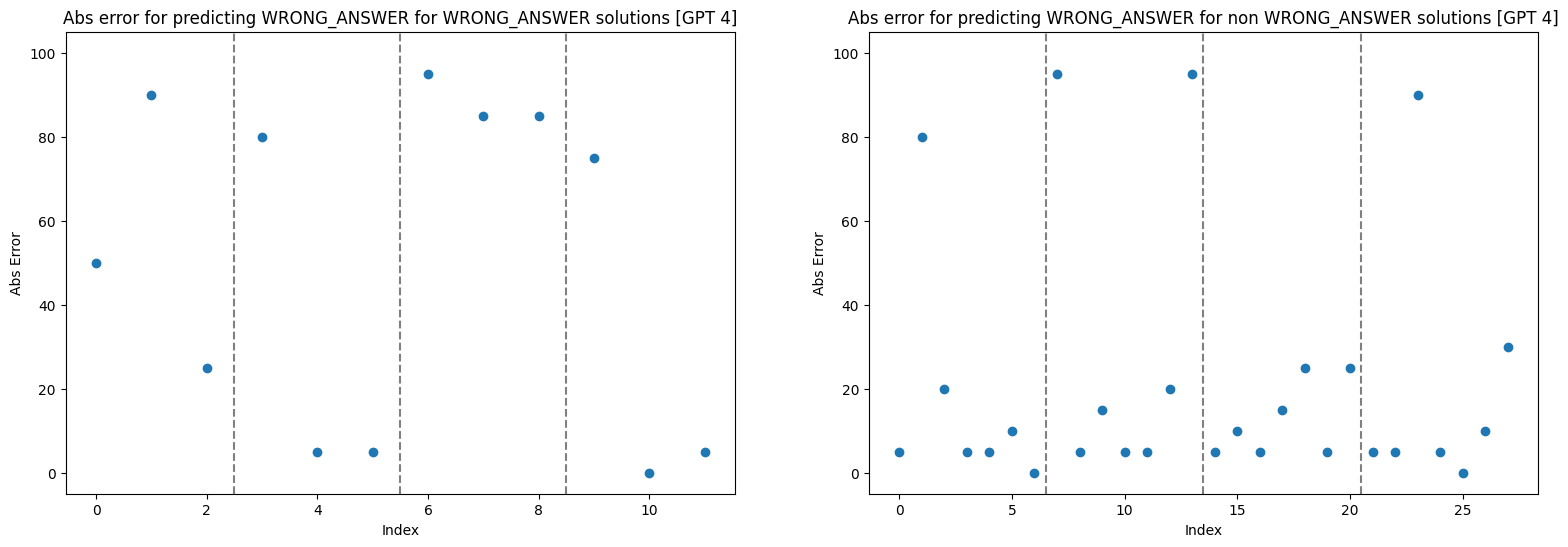

In [16]:
plot_abs_dif(engine = "defect_evaluation_gpt4_v4",  verdic_id =  0)
plot_abs_dif(engine = "defect_evaluation_gpt4_v4",  verdic_id =  1)

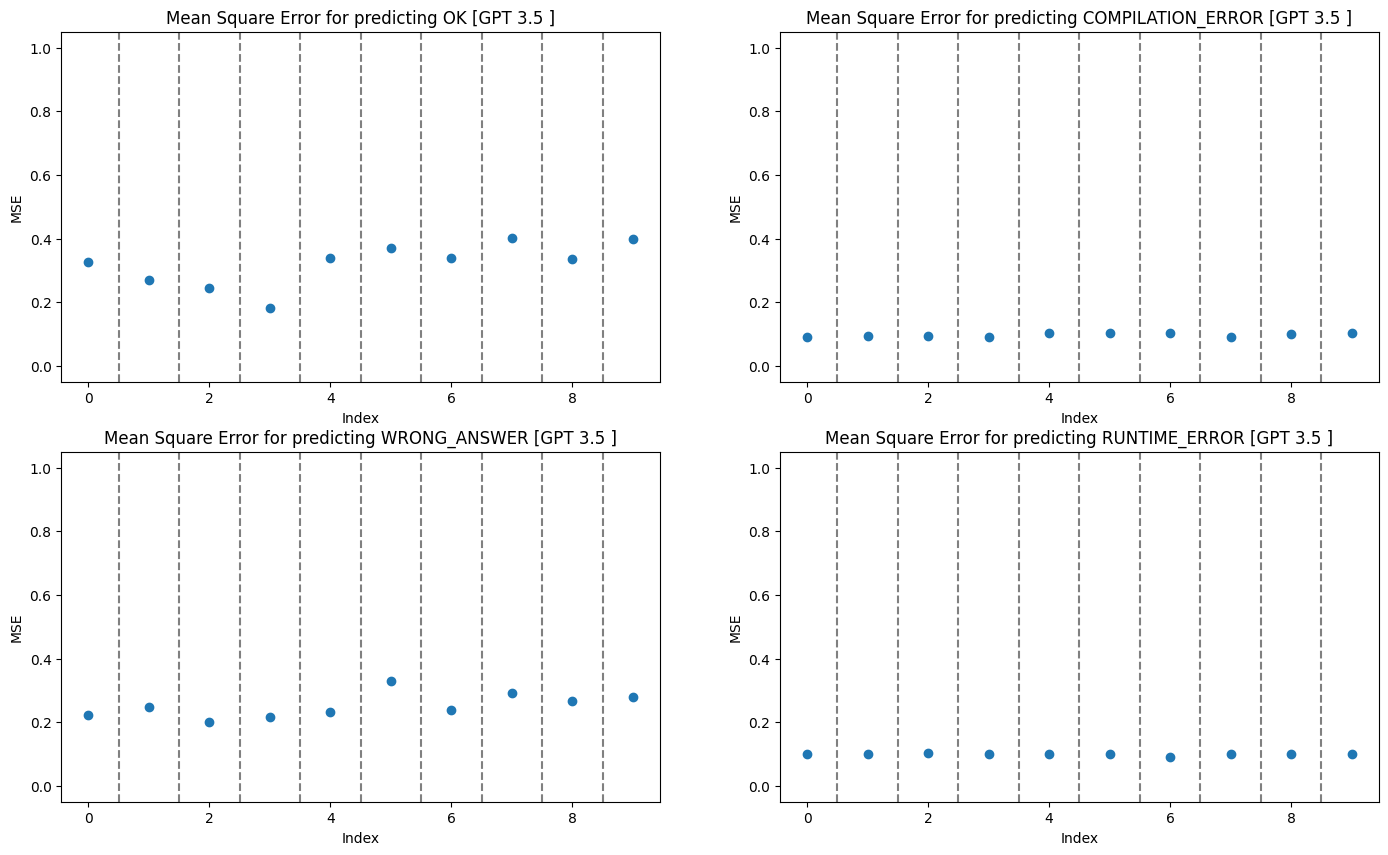

In [17]:
import numpy as np

def plot_mse(engine = "defect_evaluation_gpt4_v4"):
  fig, ax = plt.subplots(2,2, figsize=(17, 10))
  for verdic_id in range(4):
    idx = verdic_id
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)/100.0
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]

    grouped_sorted_val = [[solution.get('error')[verdic_id] for solution in solution_group if True  and 'error' in solution] for solution_group in solution_groups]

    grouped_sorted_val = [ [np.average(np.square(group))]  for group in grouped_sorted_val]

    # Flatten the list for plotting, while remembering the positions to draw lines
    flat_list = []
    lines_at = []
    current_pos = 0
    for group in grouped_sorted_val:
        flat_list.extend(group)
        current_pos += len(group)
        lines_at.append(current_pos-0.5)

    # Plot on the respective subplot
    axc = ax[idx % 2][idx // 2]
    axc.scatter(range(len(flat_list)), flat_list)

    # Add line markers to the subplot
    for line in lines_at[:-1]:  # Exclude the last line
        axc.axvline(x=line, color='grey', linestyle='--')

    # Adding labels and title to the subplot
    axc.set_xlabel('Index')
    axc.set_ylabel('MSE')
    axc.set_title(f"Mean Square Error for predicting {verdicts_str[verdic_id]} [{ 'GPT 4' if 'gpt4'  in engine else 'GPT 3.5 '}]")
    axc.set_ylim(-0.05, 1.05)
  plt.show()

plot_mse(engine = "defect_evaluation_v4")

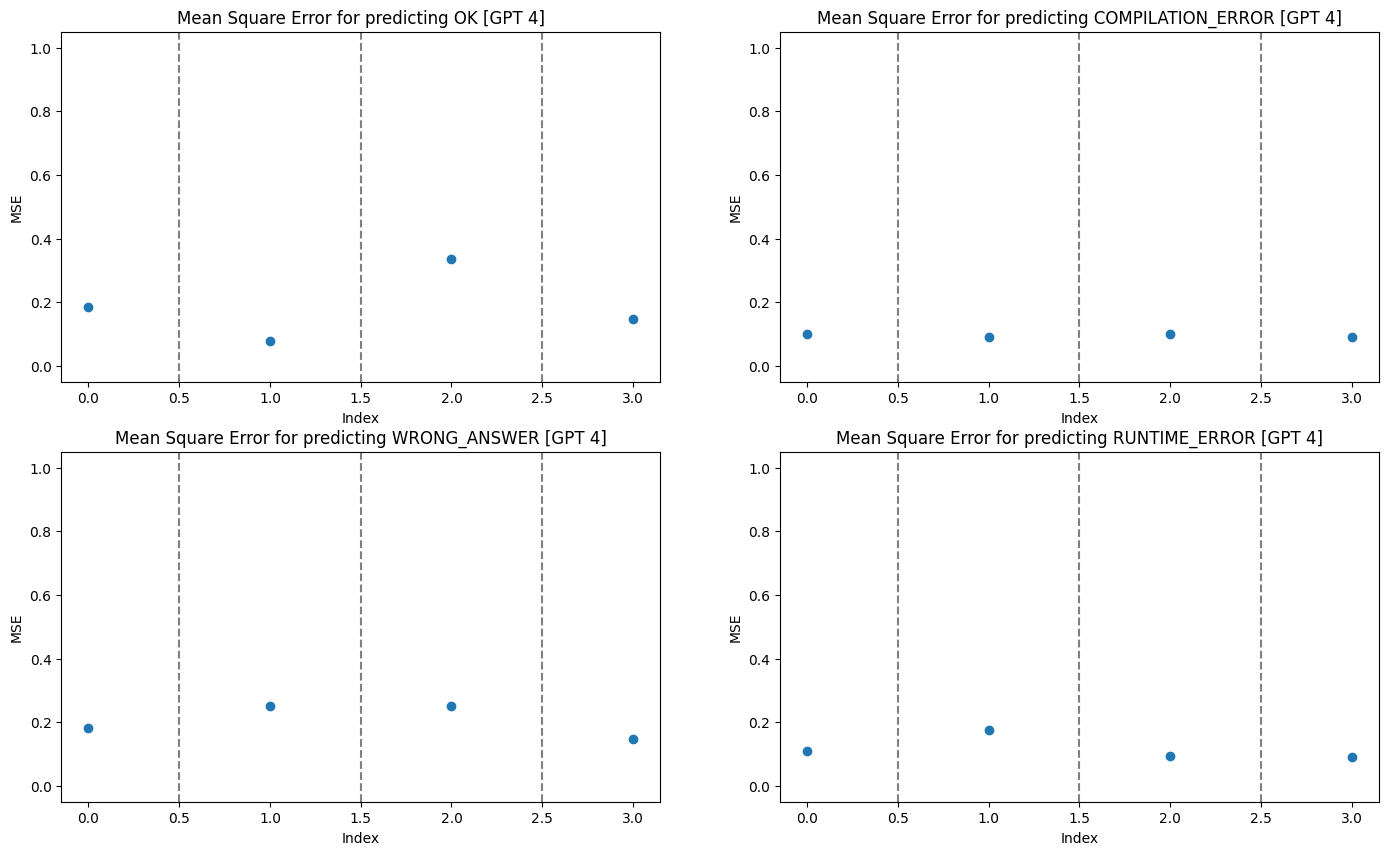

In [18]:
plot_mse(engine = "defect_evaluation_gpt4_v4")

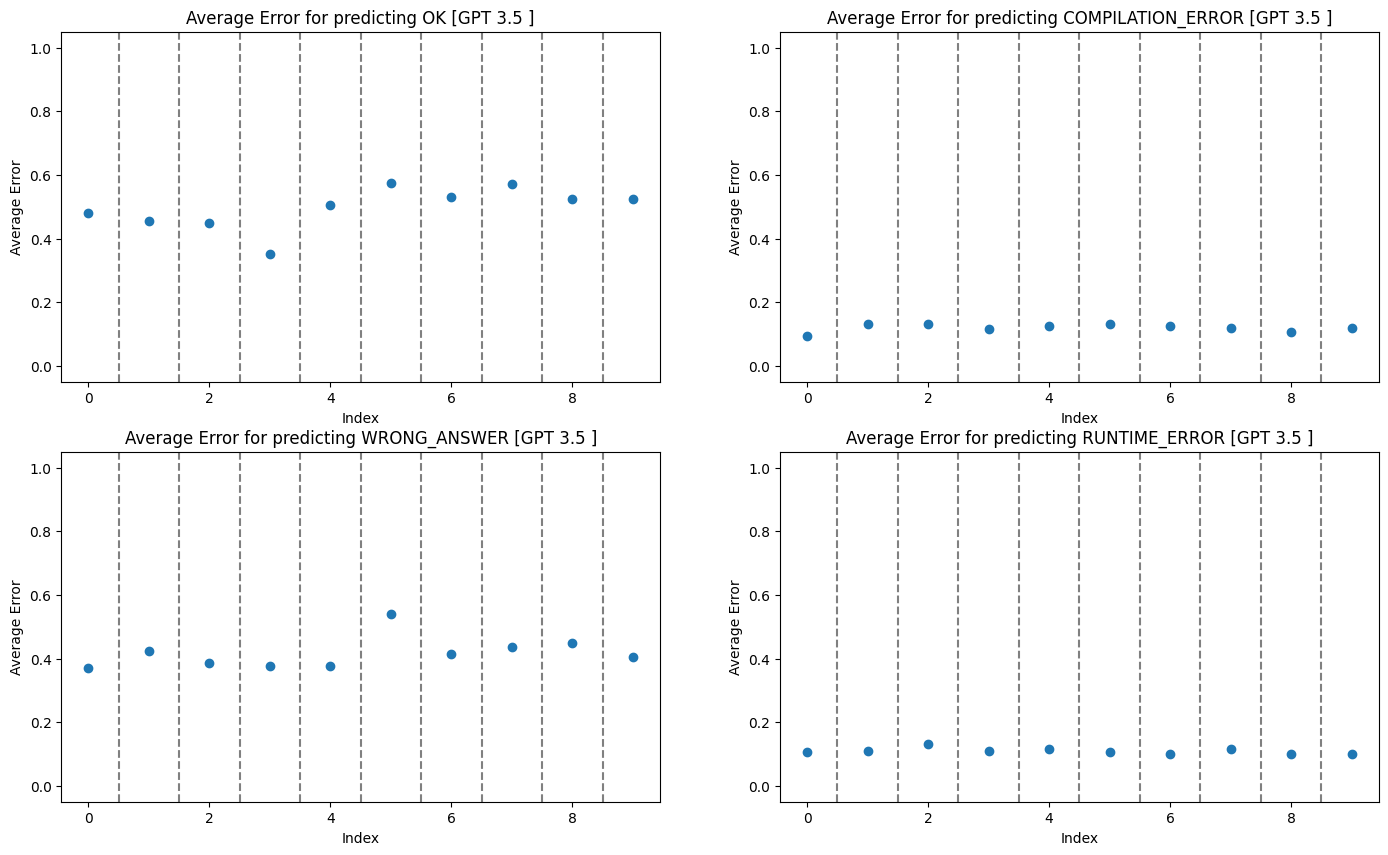

In [19]:
def plot_avg(engine = "defect_evaluation_gpt4_v4"):
  fig, ax = plt.subplots(2,2, figsize=(17, 10))
  for verdic_id in range(4):
    idx = verdic_id
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)/100.0
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]

    grouped_sorted_val = [[solution.get('error')[verdic_id] for solution in solution_group if True  and 'error' in solution] for solution_group in solution_groups]

    grouped_sorted_val = [ [np.average(np.array(group))]  for group in grouped_sorted_val]

    # Flatten the list for plotting, while remembering the positions to draw lines
    flat_list = []
    lines_at = []
    current_pos = 0
    for group in grouped_sorted_val:
        flat_list.extend(group)
        current_pos += len(group)
        lines_at.append(current_pos-0.5)

    # Plot on the respective subplot
    axc = ax[idx % 2][idx // 2]
    axc.scatter(range(len(flat_list)), flat_list)

    # Add line markers to the subplot
    for line in lines_at[:-1]:  # Exclude the last line
        axc.axvline(x=line, color='grey', linestyle='--')

    # Adding labels and title to the subplot
    axc.set_xlabel('Index')
    axc.set_ylabel('Average Error')
    axc.set_title(f"Average Error for predicting {verdicts_str[verdic_id]} [{ 'GPT 4' if 'gpt4'  in engine else 'GPT 3.5 '}]")
    axc.set_ylim(-0.05, 1.05)
  plt.show()

plot_avg(engine = "defect_evaluation_v4")

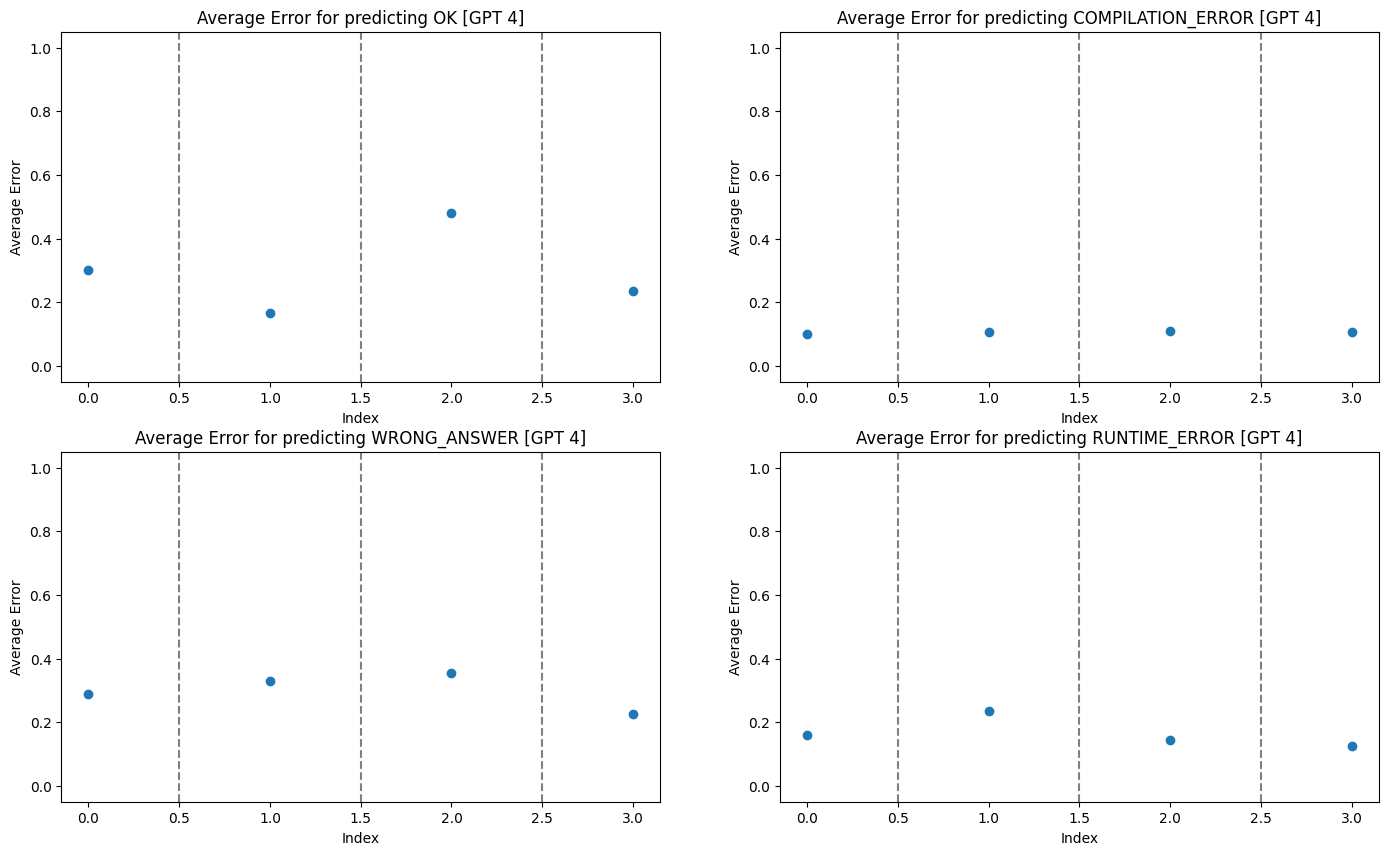

In [20]:
plot_avg(engine = "defect_evaluation_gpt4_v4")

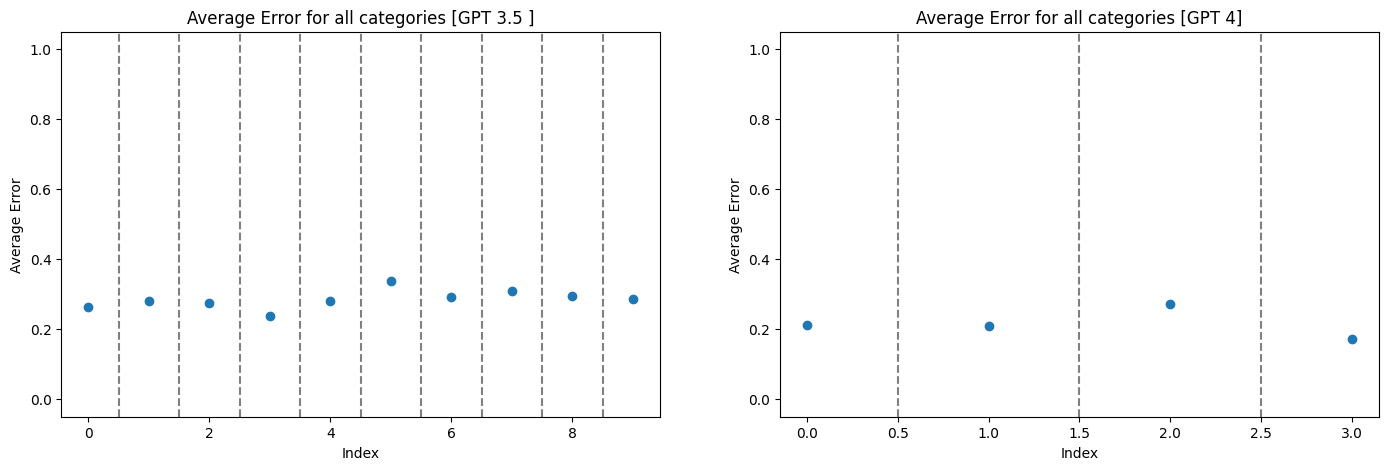

In [21]:
def plot_avg_all():
  fig, ax = plt.subplots(1,2, figsize=(17, 5))
  for idx in range(2):
    engine = ["defect_evaluation_v4","defect_evaluation_gpt4_v4"][idx]
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)/100.0
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]

    grouped_sorted_val = [[np.average(solution.get('error')) for solution in solution_group if True  and 'error' in solution] for solution_group in solution_groups]

    grouped_sorted_val = [ [np.average(np.array(group))]  for group in grouped_sorted_val]

    # Flatten the list for plotting, while remembering the positions to draw lines
    flat_list = []
    lines_at = []
    current_pos = 0
    for group in grouped_sorted_val:
        flat_list.extend(group)
        current_pos += len(group)
        lines_at.append(current_pos-0.5)

    # Plot on the respective subplot
    axc = ax[idx % 2]
    axc.scatter(range(len(flat_list)), flat_list)

    # Add line markers to the subplot
    for line in lines_at[:-1]:  # Exclude the last line
        axc.axvline(x=line, color='grey', linestyle='--')

    # Adding labels and title to the subplot
    axc.set_xlabel('Index')
    axc.set_ylabel('Average Error')
    axc.set_title(f"Average Error for all categories [{ 'GPT 4' if 'gpt4'  in engine else 'GPT 3.5 '}]")
    axc.set_ylim(-0.05, 1.05)
  plt.show()

plot_avg_all()

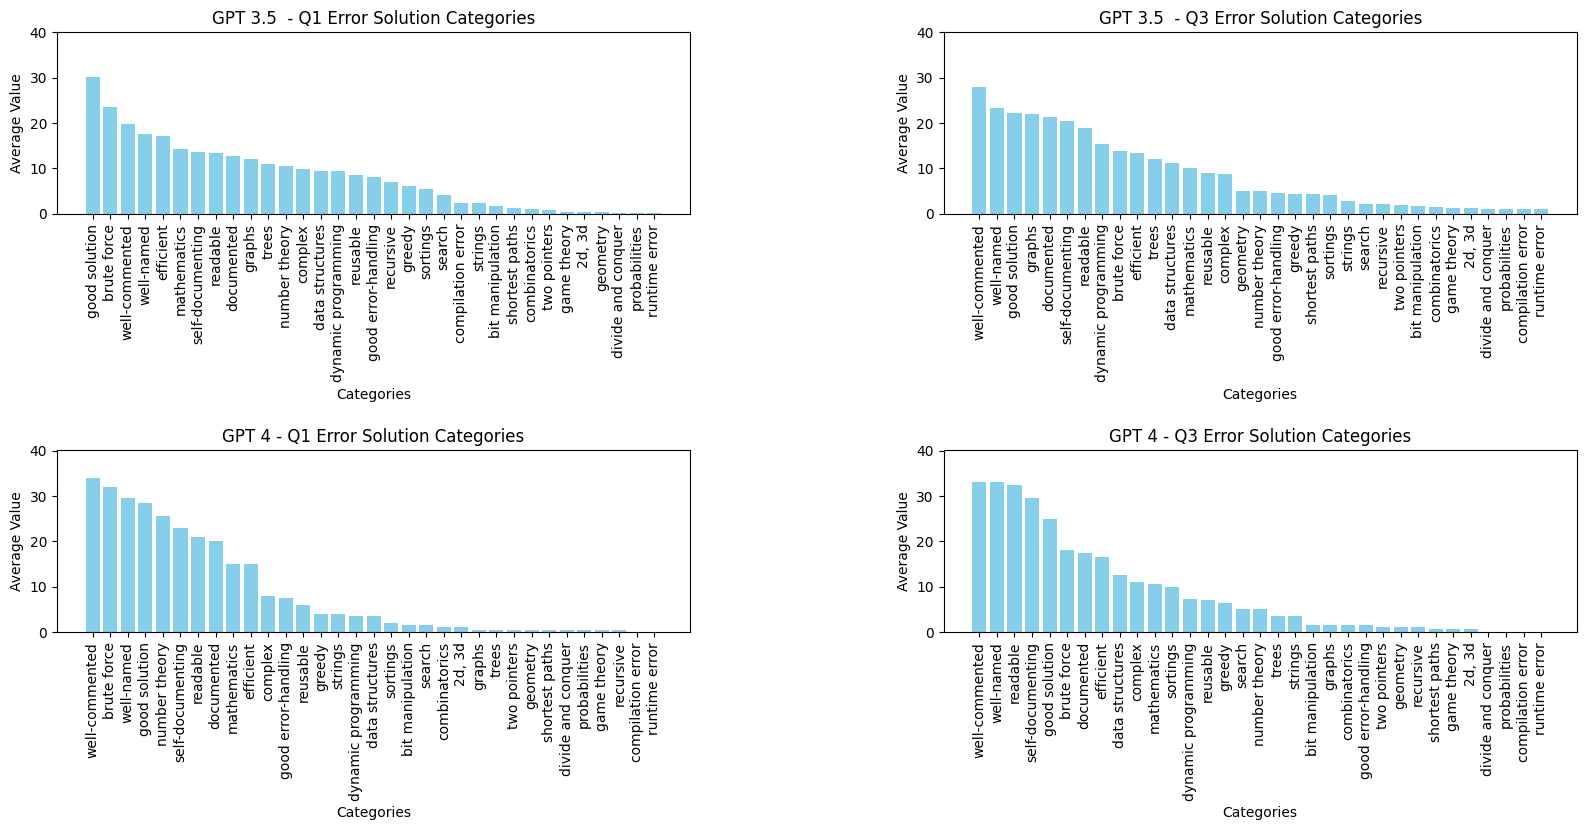

In [22]:
def dic_avg(categories):
  sums = {}

  # Step 2: Iterate over each dictionary and sum the values
  for category in categories:
      for key, value in category.items():
          sums[key] = sums.get(key, 0) + value

  # Step 3: Calculate the average for each key
  averages = {key: value / len(categories) for key, value in sums.items()}
  return averages


def plot_groups():
  fig, ax = plt.subplots(2,2, figsize=(19, 15))
  for idx in range(2):
    engine = ["defect_evaluation_v4","defect_evaluation_gpt4_v4"][idx]
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]
    merged_solutions = []
    merged_solution_vals = []
    for group in solution_groups:
      for solution in group:
        if 'error' in solution:
          merged_solutions.append(solution)
          merged_solution_vals.append(solution.get('error')[0])

    q1 = np.percentile(merged_solution_vals, 25)
    q3 = np.percentile(merged_solution_vals, 75)
    categories_q1 = dic_avg([solution['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] <= q1])
    categories_q3 = dic_avg([solution['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] >= q3])

    for id, categories in enumerate([categories_q1, categories_q3]):
      sorted_categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)

      # Separating keys and values for plotting
      categories_names, values = zip(*sorted_categories)

      axc = ax[idx][id]
      #axc = ax[idx*2+ id]
      axc.bar(categories_names, values, color='skyblue')
      axc.set_xlabel('Categories')
      axc.set_ylabel('Average Value')
      axc.set_title(f'{ "GPT 4" if "gpt4"  in engine else "GPT 3.5 "} - {"Q1" if id == 0 else "Q3"} Error Solution Categories')
      axc.tick_params(axis='x', rotation=90)
      axc.set_ylim(-0.05, 40.05)

  plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, wspace=0.4, hspace=1.3)
  plt.show()

plot_groups()

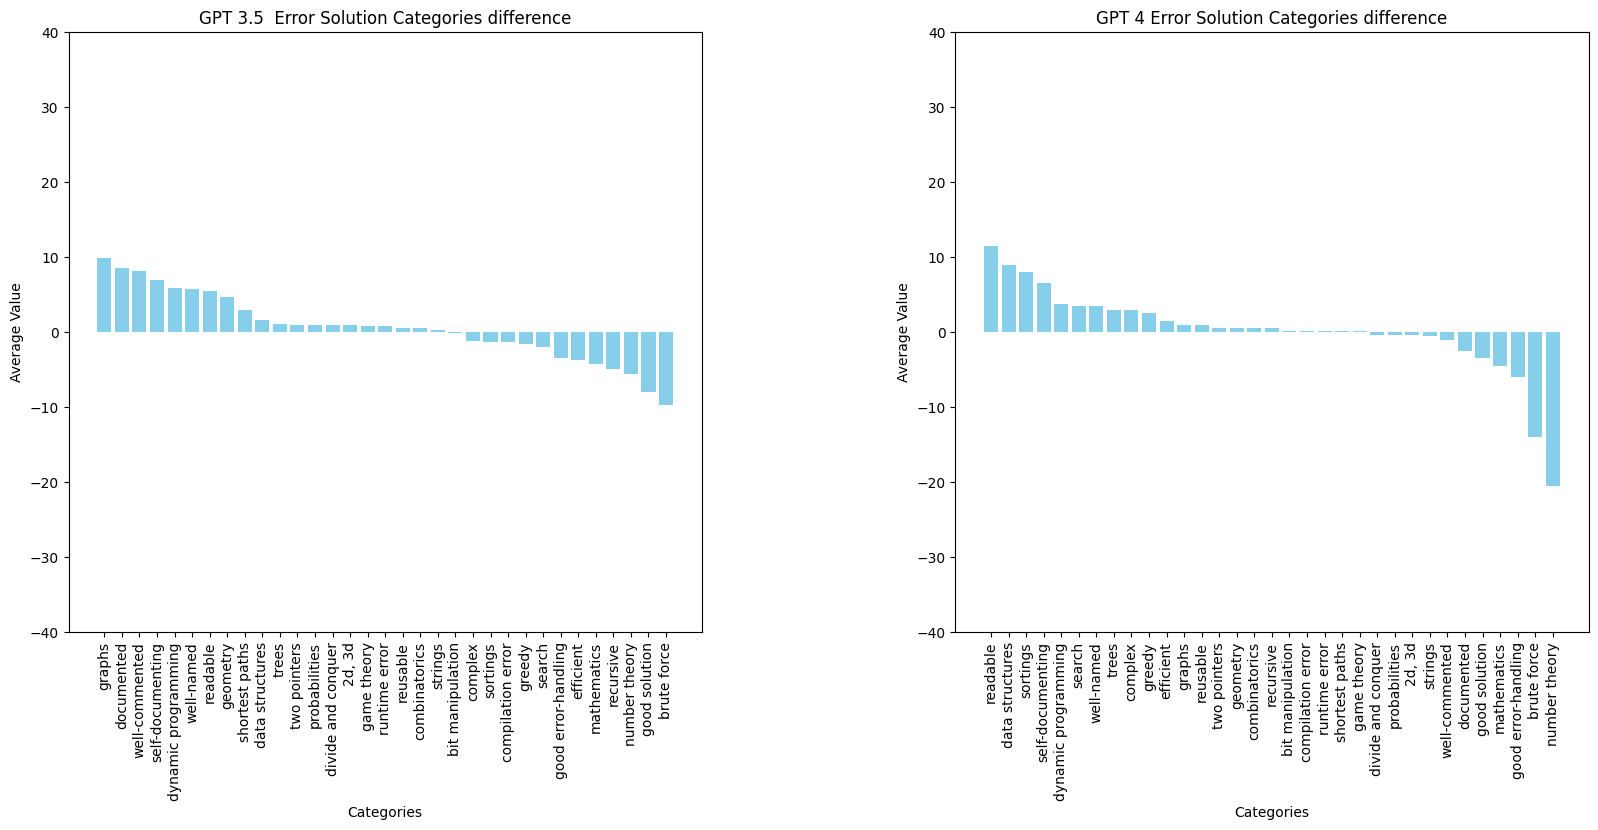

In [23]:
def subtract_dicts(dict1, dict2):
    result = {}
    for key in dict1:
        if key in dict2:
            result[key] = dict1[key] - dict2[key]
        else:
            result[key] = dict1[key]  # or handle the missing key as needed
    return result
def plot_group_difs():
  fig, ax = plt.subplots(1,2, figsize=(19, 15))
  for idx in range(2):
    engine = ["defect_evaluation_v4","defect_evaluation_gpt4_v4"][idx]
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]
    merged_solutions = []
    merged_solution_vals = []
    for group in solution_groups:
      for solution in group:
        if 'error' in solution:
          merged_solutions.append(solution)
          merged_solution_vals.append(solution.get('error')[0])

    q1 = np.percentile(merged_solution_vals, 25)
    q3 = np.percentile(merged_solution_vals, 75)
    categories_q1 = dic_avg([solution['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] <= q1])
    categories_q3 = dic_avg([solution['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] >= q3])

    categories_diff = subtract_dicts(categories_q3 , categories_q1)
    for id, categories in enumerate([categories_diff]):
      sorted_categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)

      # Separating keys and values for plotting
      categories_names, values = zip(*sorted_categories)

      #axc = ax[idx][id]
      axc = ax[idx]
      axc.bar(categories_names, values, color='skyblue')
      axc.set_xlabel('Categories')
      axc.set_ylabel('Average Value')
      axc.set_title(f'{ "GPT 4" if "gpt4"  in engine else "GPT 3.5 "} Error Solution Categories difference')
      axc.tick_params(axis='x', rotation=90)
      axc.set_ylim(-40, 40)

  plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, wspace=0.4, hspace=1.3)
  plt.show()

plot_group_difs()

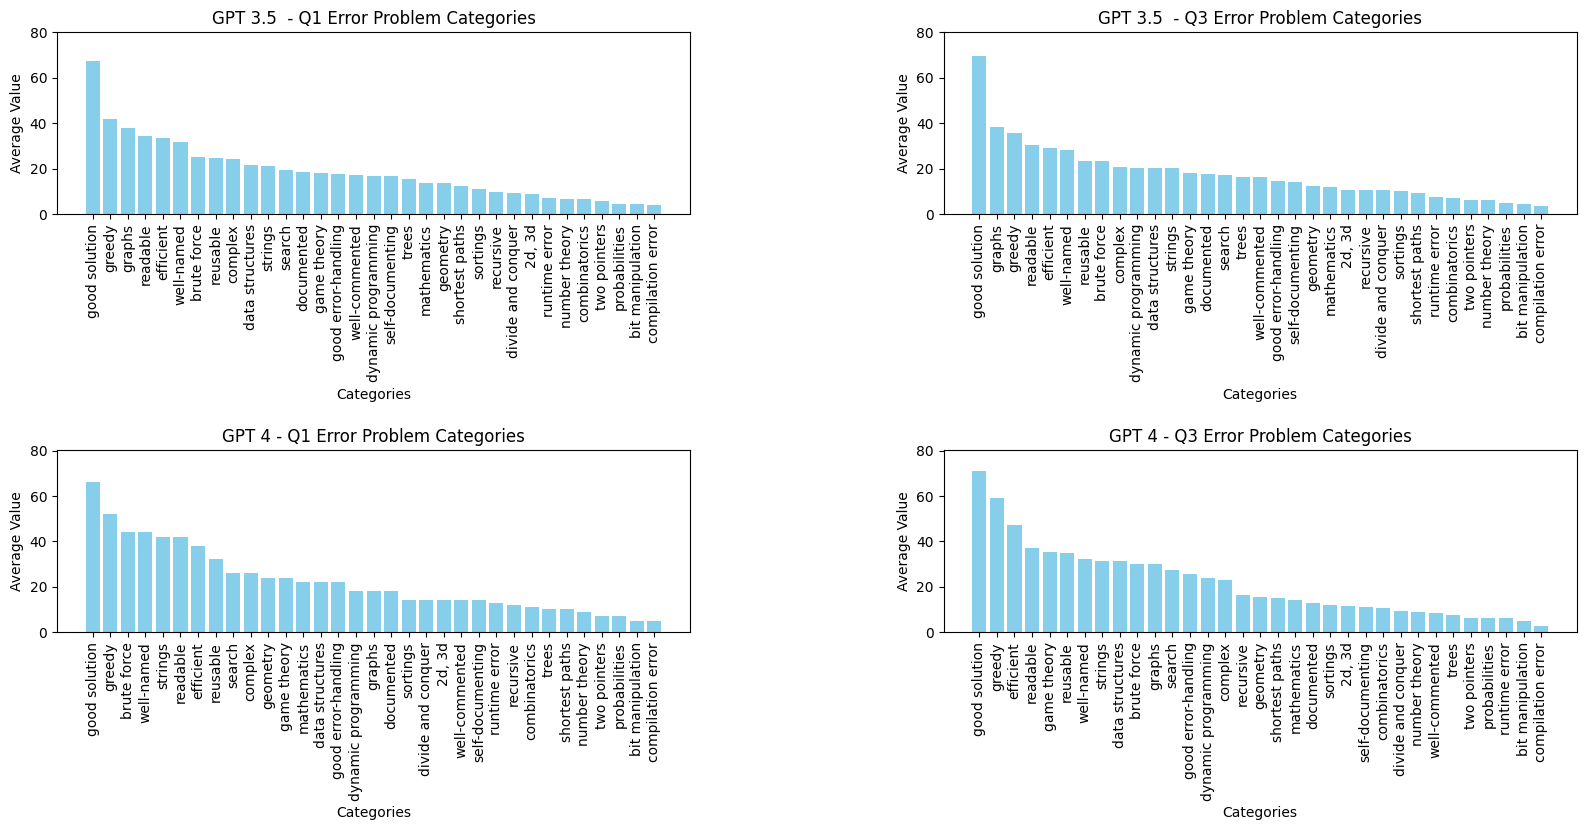

In [24]:
for problem_id, problem in enumerate(problems):
  ids = problem_solution_container.get_solutions_for_problem(problem_id)
  for id in ids:
    solutions[id]['problem_obj']=problem

def plot_groups_problem():
  fig, ax = plt.subplots(2,2, figsize=(19, 15))
  for idx in range(2):
    engine = ["defect_evaluation_v4","defect_evaluation_gpt4_v4"][idx]
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]
    merged_solutions = []
    merged_solution_vals = []
    for group in solution_groups:
      for solution in group:
        if 'error' in solution:
          merged_solutions.append(solution)
          merged_solution_vals.append(solution.get('error')[0])

    q1 = np.percentile(merged_solution_vals, 25)
    q3 = np.percentile(merged_solution_vals, 75)
    categories_q1 = dic_avg([solution['problem_obj']['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] <= q1])
    categories_q3 = dic_avg([solution['problem_obj']['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] >= q3])

    for id, categories in enumerate([categories_q1, categories_q3]):
      sorted_categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)

      # Separating keys and values for plotting
      categories_names, values = zip(*sorted_categories)

      axc = ax[idx][id]
      #axc = ax[idx*2+ id]
      axc.bar(categories_names, values, color='skyblue')
      axc.set_xlabel('Categories')
      axc.set_ylabel('Average Value')
      axc.set_title(f'{ "GPT 4" if "gpt4"  in engine else "GPT 3.5 "} - {"Q1" if id == 0 else "Q3"} Error Problem Categories')
      axc.tick_params(axis='x', rotation=90)
      axc.set_ylim(-0.05, 80.05)

  plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, wspace=0.4, hspace=1.3)
  plt.show()

plot_groups_problem()

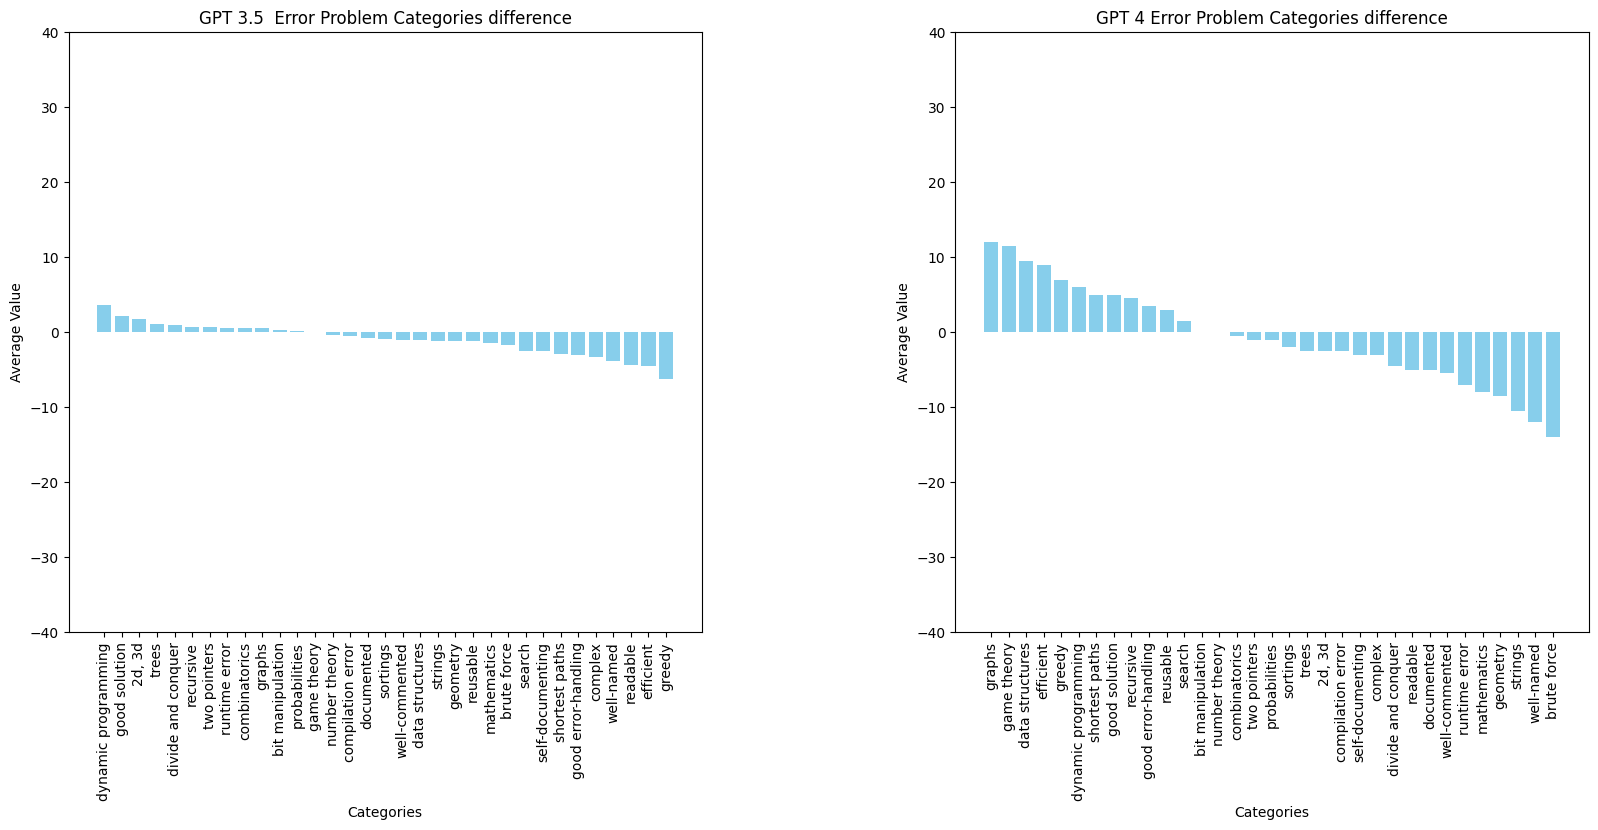

In [25]:
def plot_group_difs_problem():
  fig, ax = plt.subplots(1,2, figsize=(19, 15))
  for idx in range(2):
    engine = ["defect_evaluation_v4","defect_evaluation_gpt4_v4"][idx]
    for solution in solutions:
      val = [0,0,0,0]
      if engine in solution:
        for i in range(4):
          true_val = 100 if solution['verdict'] == verdicts_str[i] else 0
          val[i] = abs(solution[engine][eval_str[i]] - true_val)
        solution['error'] = val

    rev_problem_ids=[]
    for problem_id, problem in enumerate(problems):
      ids = problem_solution_container.get_solutions_for_problem(problem_id)
      for id in ids:
        if engine in solutions[id]:
          rev_problem_ids.append(problem_id)
          break

    solution_groups = [[solutions[sol_id] for sol_id in problem_solution_container.get_solutions_for_problem(problem_id)] for problem_id in rev_problem_ids]
    merged_solutions = []
    merged_solution_vals = []
    for group in solution_groups:
      for solution in group:
        if 'error' in solution:
          merged_solutions.append(solution)
          merged_solution_vals.append(solution.get('error')[0])

    q1 = np.percentile(merged_solution_vals, 25)
    q3 = np.percentile(merged_solution_vals, 75)
    categories_q1 = dic_avg([solution['problem_obj']['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] <= q1])
    categories_q3 = dic_avg([solution['problem_obj']['category_evaluation'] for solution in merged_solutions if solution.get('error')[0] >= q3])

    categories_diff = subtract_dicts(categories_q3 , categories_q1)
    for id, categories in enumerate([categories_diff]):
      sorted_categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)

      # Separating keys and values for plotting
      categories_names, values = zip(*sorted_categories)

      #axc = ax[idx][id]
      axc = ax[idx]
      axc.bar(categories_names, values, color='skyblue')
      axc.set_xlabel('Categories')
      axc.set_ylabel('Average Value')
      axc.set_title(f'{ "GPT 4" if "gpt4"  in engine else "GPT 3.5 "} Error Problem Categories difference')
      axc.tick_params(axis='x', rotation=90)
      axc.set_ylim(-40, 40)

  plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1, wspace=0.4, hspace=1.3)
  plt.show()

plot_group_difs_problem()